# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

In [1]:
import sys; sys.path.append("..")
import numpy as np
from utils.optimization import gd, sgd
import matplotlib.pyplot as plt
import scipy

np.random.seed(42)

## Dataset creation

In [2]:
def generalizedVander(funcs, x):
    V = np.zeros((len(x), len(funcs)))
    for j, fn in enumerate(funcs):
        V[:, j] = fn(np.array(x))
    return V

def Phi(X, K):
    return generalizedVander([ (lambda x, coef=j: x**coef) for j in range(K) ], X)


def createDataset(N, a, b, K, theta_true, variance, random_seed=42):
    X_full = np.linspace(a, b, N)
    Y_full = Phi(X_full, K) @ theta_true + np.random.default_rng(random_seed).normal(0, np.sqrt(variance), N)
    return X_full, Y_full

def train_test_split(X, Y, train_size, random_seed=42):
    idxs = np.arange(0, X.shape[0])
    np.random.default_rng(random_seed).shuffle(idxs)
    X_train = X[idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test

In [3]:
N = 1500
K = 4
a, b = -1, 1
variance = 0.2
theta_true = np.ones(K)

X_full, Y_full = createDataset(N, a, b, K, theta_true, variance)
X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

print(f"Train shape: {X_train.shape} | {Y_train.shape}")
print(f"Test shape: {X_test.shape} | {Y_test.shape}")

Train shape: (1125,) | (1125,)
Test shape: (375,) | (375,)


## Evaluation utilities

In [4]:
def avgAbsoluteError(model, X, Y):
    assert model.predict(X).shape == Y.shape
    return (1/Y.shape[0]) * (np.linalg.norm(model.predict(X) - Y, 2)**2)

def thetaError(model, theta_true):
    padded_theta = np.zeros(model.theta.shape)
    padded_theta[:theta_true.shape[0]] = theta_true
    assert model.theta.shape == padded_theta.shape
    return np.linalg.norm(model.theta - padded_theta, 2) / np.linalg.norm(padded_theta, 2)

In [5]:
def plotDataForVaryingK(model, X_train, Y_train, X_test, Y_test, real_K, K_variation=3, fig_size=(18, 6)):
    to_test_K = [*range(max(1, real_K-K_variation), real_K)] + [real_K] + [*range(real_K+1, real_K+K_variation+1)]
    train_errors = []
    test_errors = []

    plt.figure(figsize=fig_size)
    
    plt.subplot(1, 2, 1)
    plt.title("Datapoints")
    plt.plot(X_train, Y_train, ".", alpha=0.3, label="Train data")
    plt.plot(X_test, Y_test, ".", alpha=0.3, label="Test data")
    for K in to_test_K:
        model.K = K
        model.fit(X_train, Y_train, epochs=1000)
        train_errors.append( avgAbsoluteError(model, X_train, Y_train) )
        test_errors.append( avgAbsoluteError(model, X_test, Y_test) )

        print(f"K={K} | Avg absolute error: [test] {test_errors[-1]:<20} | [train] {train_errors[-1]:<20}")
        plot_X = np.linspace(a, b, 10000)
        plt.plot(plot_X, model.predict(plot_X), "-", label=f"K={K}", linewidth=2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Average absolute errors")
    plt.plot(to_test_K, train_errors, label="Train")
    plt.plot(to_test_K, test_errors, label="Test")
    plt.xlabel("K")
    plt.xticks(to_test_K)
    plt.legend()
    plt.show()

## Maximum Likelihood Estimation

In [6]:
class Regressor:
    def __init__(self, K):
        self.theta = None
        self.K = K

    def _loss(self, theta, Phi_X, Y):
        raise NotImplementedError()

    def _grad_loss(self, theta, Phi_X, Y):
        raise NotImplementedError()

    def fit(self, X, Y, batch_size=500, epochs=100, lr=1e-3):
        history_w, history_loss, history_grad, history_err = sgd(
            loss = self._loss, 
            grad_loss = self._grad_loss,
            w0 = np.zeros(self.K),
            data = (Phi(X, self.K).T, Y),
            batch_size = batch_size,
            n_epochs = epochs,
            lr = lr,
        )

        # print(f"Loss: {[round(h, 2) for h in history_loss]}")
        # print(f"Gradient norm: {[round(h, 2) for h in history_err]}")
        self.theta = history_w[-1]
        return self

    def fit_gd(self, X, Y, epochs=100, tol_loss=1e-6, tol_theta=1e-6, lr=1e-3):
        history_w, curr_k, history_loss, history_grad, history_err = gd(
            loss = self._loss, 
            grad_loss = self._grad_loss,
            w0 = np.zeros(self.K),
            data = (Phi(X, self.K).T, Y),
            k_max = epochs,
            tol_loss = tol_loss,
            tol_w = tol_theta,
            alpha = None
        )
        self.theta = history_w[-1]
        return self
        

    def predict(self, X):
        return Phi(X, self.K) @ self.theta

In [7]:
class MLERegressor(Regressor):
    def __init__(self, K):
        super().__init__(K)

    def _loss(self, theta, Phi_X, Y):
        return (1/2)*np.linalg.norm(Y - (theta @ Phi_X))**2

    def _grad_loss(self, theta, Phi_X, Y):
        return -(Y.T @ Phi_X.T - theta.T @ Phi_X @ Phi_X.T)
    

    def fit_neq(self, X, Y):
        Phi_X = Phi(X, self.K)
        self.theta = scipy.linalg.cho_solve( scipy.linalg.cho_factor(Phi_X.T @ Phi_X), (Phi_X.T @ Y) )
        return self

K=1 | Avg absolute error: [test] 0.945386663440035    | [train] 1.2550755431937402  
K=2 | Avg absolute error: [test] 0.27123719499554744  | [train] 0.3290935711245108  
K=3 | Avg absolute error: [test] 0.23119943473556967  | [train] 0.22047818598194696 
K=4 | Avg absolute error: [test] 0.20861307816382108  | [train] 0.19755426621142305 
K=5 | Avg absolute error: [test] 0.20863654710708346  | [train] 0.19748403773273793 
K=6 | Avg absolute error: [test] 0.20859985674150372  | [train] 0.19753106189095151 
K=7 | Avg absolute error: [test] 0.20860171869867838  | [train] 0.1975688885307371  


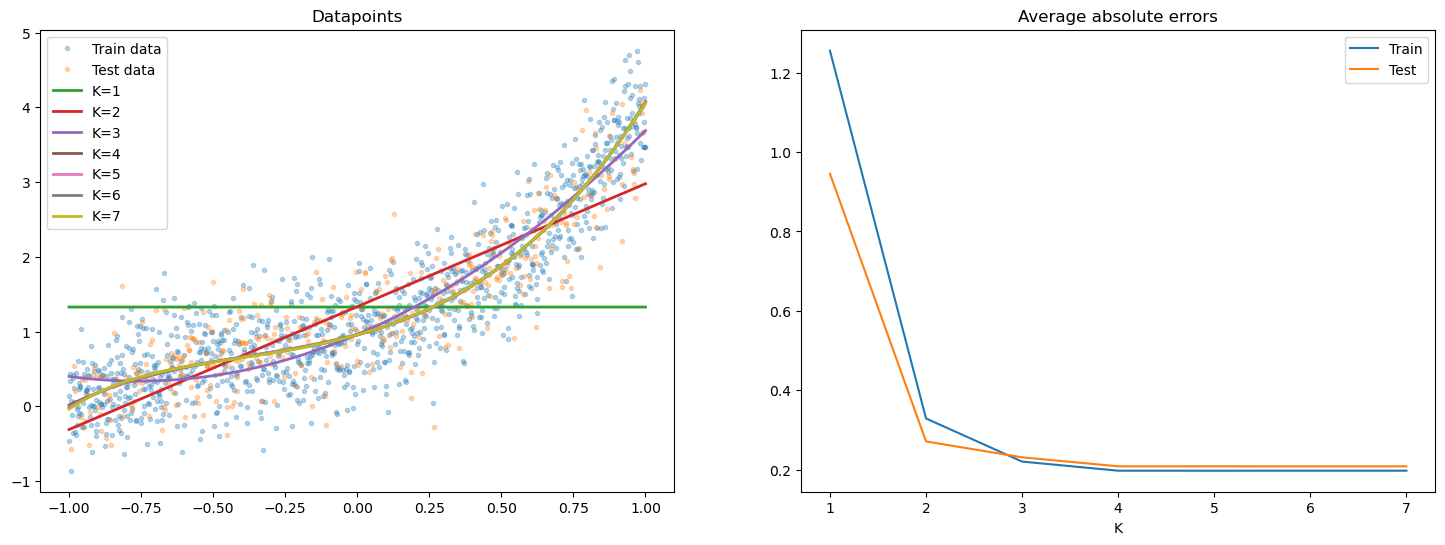

In [8]:
plotDataForVaryingK(MLERegressor(K=None), X_train, Y_train, X_test, Y_test, real_K=K)

## Maximum a Posteriori

### Fixed $\lambda$, varying $K$

In [9]:
class MAPRegressor(Regressor):
    def __init__(self, K, lamb):
        super().__init__(K)
        self.lamb = lamb

    def _loss(self, theta, Phi_X, Y):
        return (1/2)*(np.linalg.norm(Y - (theta @ Phi_X))**2) + (1/2)*(self.lamb*np.linalg.norm(theta, 2)**2)

    def _grad_loss(self, theta, Phi_X, Y):
        return -(Y.T @ Phi_X.T - theta.T @ Phi_X @ Phi_X.T) + (self.lamb*theta)
    
    def fit_neq(self, X, Y):
        Phi_X = Phi(X, self.K)
        self.theta = scipy.linalg.cho_solve( scipy.linalg.cho_factor((Phi_X.T @ Phi_X) + (self.lamb*np.identity(Phi_X.shape[1]))), (Phi_X.T @ Y) )
        return self

>>>>> lambda = 0.1 <<<<<
K=2 | Avg absolute error: [test] 0.2710743285187329   | [train] 0.3290973964201391  
K=3 | Avg absolute error: [test] 0.2309632332083886   | [train] 0.2204828675419966  
K=4 | Avg absolute error: [test] 0.20845053836945202  | [train] 0.19755823744213263 
K=5 | Avg absolute error: [test] 0.20842389967533054  | [train] 0.19750396264480122 
K=6 | Avg absolute error: [test] 0.20839292666177778  | [train] 0.19756323995477787 


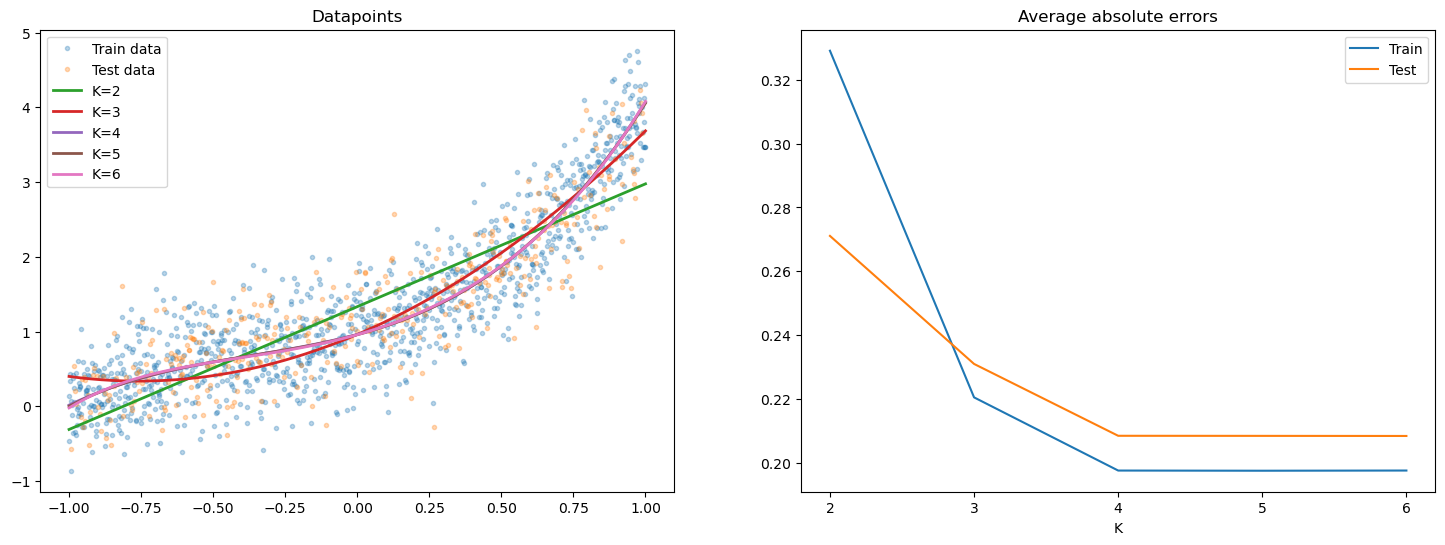

>>>>> lambda = 0.325 <<<<<
K=2 | Avg absolute error: [test] 0.2707138013500036   | [train] 0.32911150124844873 
K=3 | Avg absolute error: [test] 0.2304418847348737   | [train] 0.2205016061190918  
K=4 | Avg absolute error: [test] 0.20809309990452535  | [train] 0.19757552103101372 
K=5 | Avg absolute error: [test] 0.20804423650790174  | [train] 0.19759766793989236 
K=6 | Avg absolute error: [test] 0.2080241052019183   | [train] 0.19767823295142536 


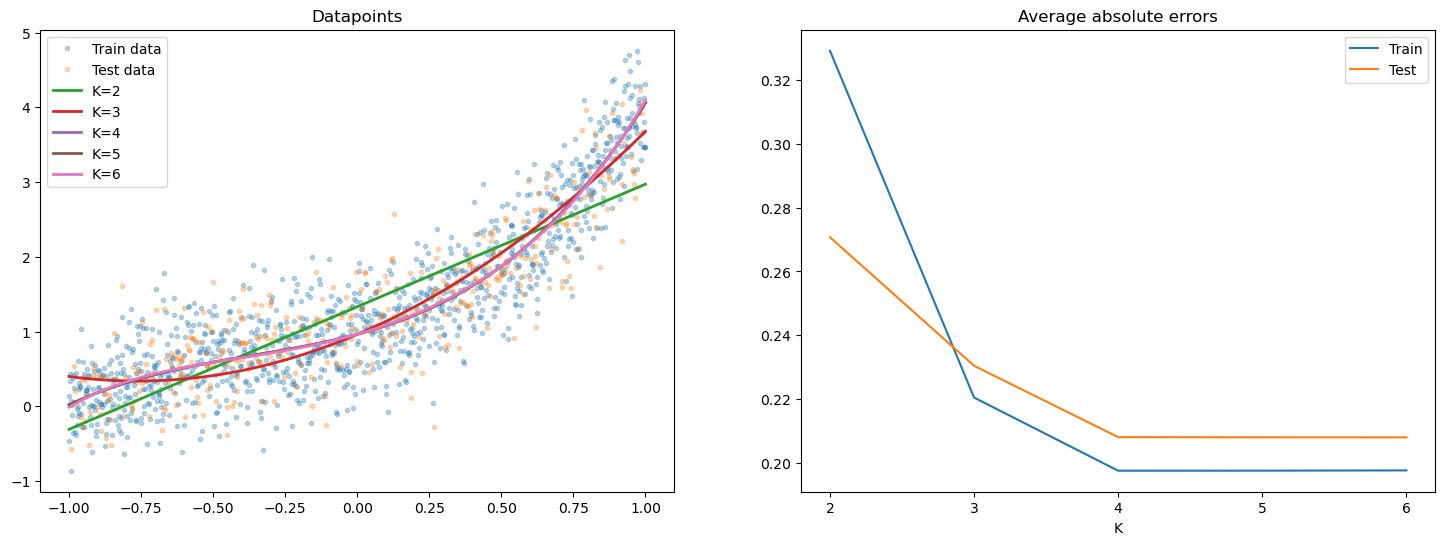

>>>>> lambda = 0.55 <<<<<
K=2 | Avg absolute error: [test] 0.270361419315772    | [train] 0.32913316350966504 
K=3 | Avg absolute error: [test] 0.22993430584321553  | [train] 0.22053151249427697 
K=4 | Avg absolute error: [test] 0.20774663305268878  | [train] 0.19760372807309665 
K=5 | Avg absolute error: [test] 0.20775057474881184  | [train] 0.1977250030249571  
K=6 | Avg absolute error: [test] 0.20773738761353097  | [train] 0.19781865772411247 


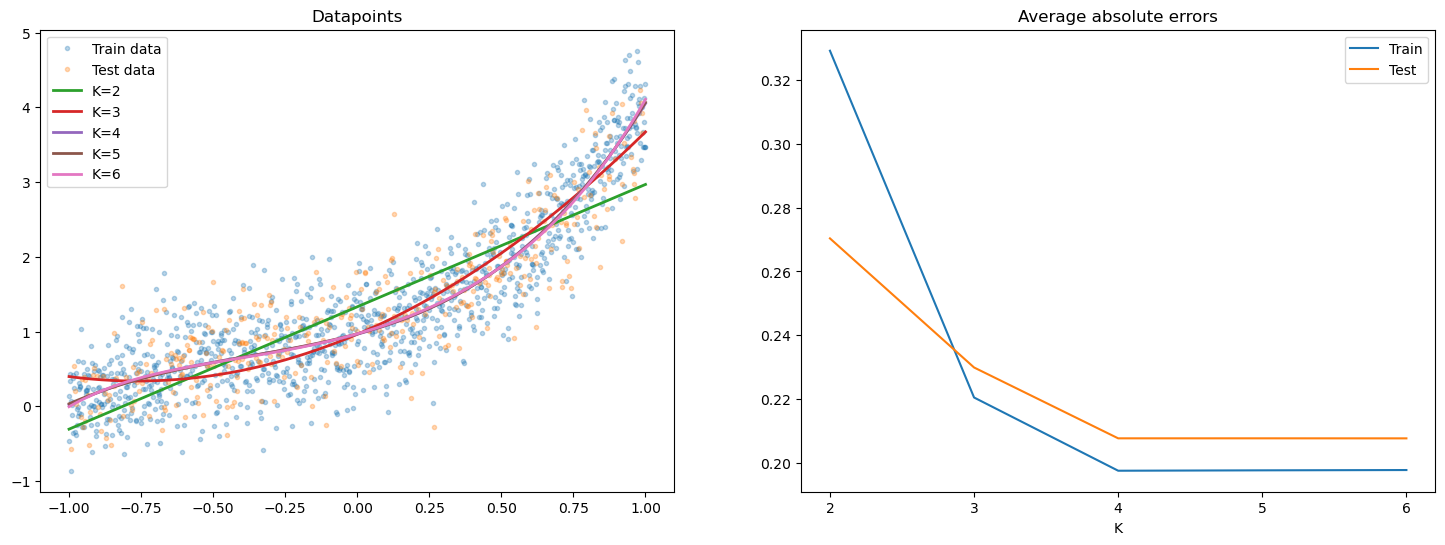

>>>>> lambda = 0.775 <<<<<
K=2 | Avg absolute error: [test] 0.27001711532605616  | [train] 0.3291623161975854  
K=3 | Avg absolute error: [test] 0.22944023163091287  | [train] 0.22057235654395585 
K=4 | Avg absolute error: [test] 0.2074106184177178   | [train] 0.1976421799308242  
K=5 | Avg absolute error: [test] 0.2075067379829849   | [train] 0.19786455170743228 
K=6 | Avg absolute error: [test] 0.2074969680459126   | [train] 0.19796459229972851 


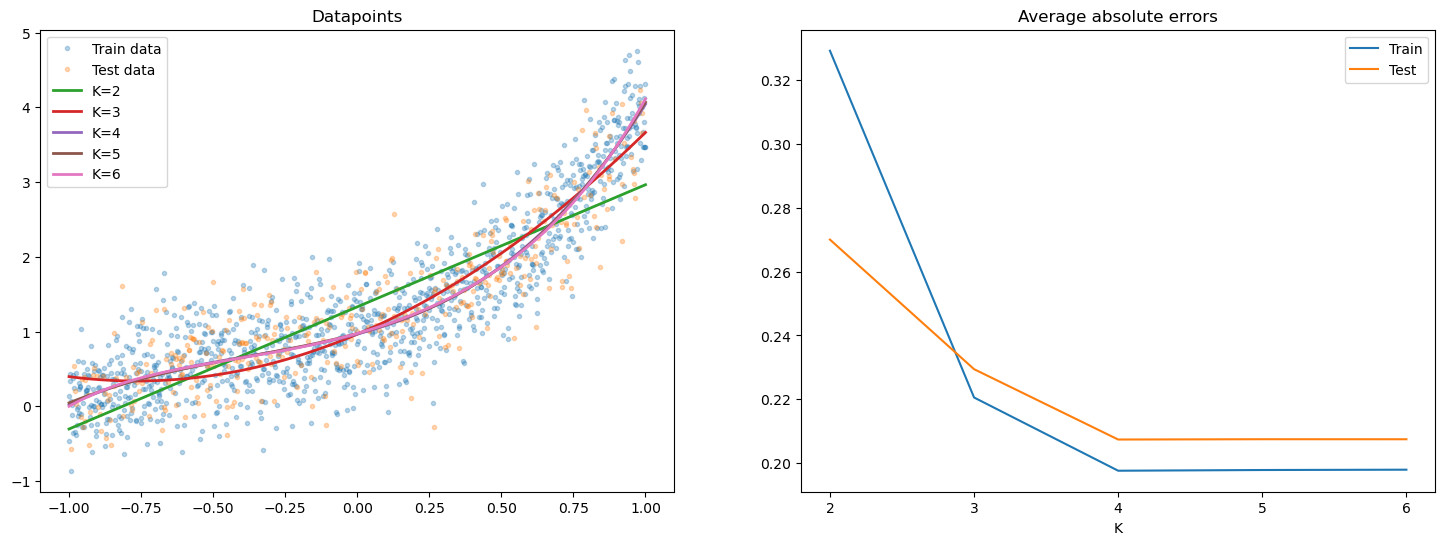

>>>>> lambda = 1.0 <<<<<
K=2 | Avg absolute error: [test] 0.2696808229279126   | [train] 0.32919889296149357 
K=3 | Avg absolute error: [test] 0.22895940550621438  | [train] 0.22062391575314833 
K=4 | Avg absolute error: [test] 0.2070846115242449   | [train] 0.1976902955527179  
K=5 | Avg absolute error: [test] 0.20729322705799294  | [train] 0.19800690252404654 
K=6 | Avg absolute error: [test] 0.20728424825415898  | [train] 0.19810813968601435 


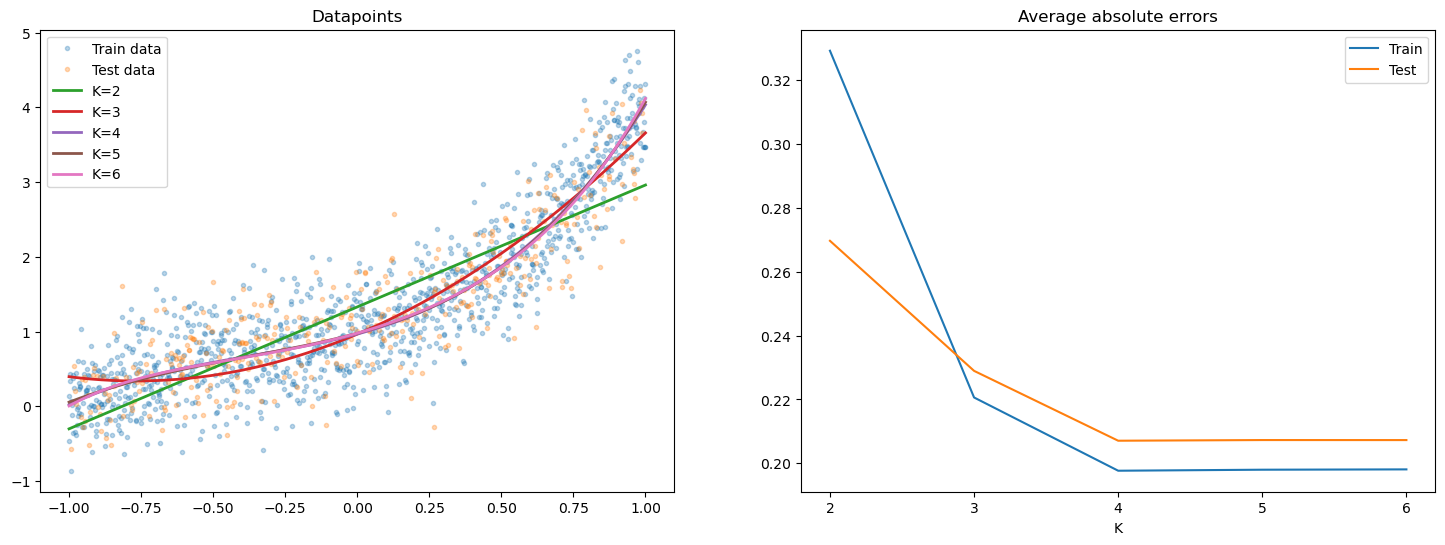

In [10]:
for to_try_lambda in np.linspace(0.1, 1, 5):
    print(f">>>>> lambda = {to_try_lambda} <<<<<")
    plotDataForVaryingK(MAPRegressor(K=None, lamb=to_try_lambda), X_train, Y_train, X_test, Y_test, real_K=K, K_variation=2, fig_size=(18,6))

### Fixed $K$, varying $\lambda$

In [11]:
def plotDataForVaryingLambda(model, X_train, Y_train, X_test, Y_test, to_try_lambda, fig_size=(18, 6)):
    train_errors = []
    test_errors = []

    plt.figure(figsize=fig_size)
    
    plt.subplot(1, 2, 1)
    plt.title("Datapoints")
    plt.plot(X_train, Y_train, ".", alpha=0.3, label="Train data")
    plt.plot(X_test, Y_test, ".", alpha=0.3, label="Test data")
    for lamb in to_try_lambda:
        model.lamb = lamb
        model.fit(X_train, Y_train, epochs=1000)
        train_errors.append( avgAbsoluteError(model, X_train, Y_train) )
        test_errors.append( avgAbsoluteError(model, X_test, Y_test) )

        print(f"Lambda={lamb:.3f} | Avg absolute error: [test] {test_errors[-1]:<20} | [train] {train_errors[-1]:<20}")
        plot_X = np.linspace(a, b, 10000)
        plt.plot(plot_X, model.predict(plot_X), "-", label=f"Lambda={lamb:.3f}", linewidth=2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Average absolute errors")
    plt.plot(to_try_lambda, train_errors, label="Train")
    plt.plot(to_try_lambda, test_errors, label="Test")
    plt.xlabel("Lambda")
    plt.xticks(to_try_lambda)
    plt.legend()
    plt.show()

>>>>> K = 3 <<<<<
Lambda=0.100 | Avg absolute error: [test] 0.2309632332083886   | [train] 0.2204828675419966  
Lambda=0.311 | Avg absolute error: [test] 0.23047366522607224  | [train] 0.22050012360872387 
Lambda=0.522 | Avg absolute error: [test] 0.22999623391090085  | [train] 0.22052722394863525 
Lambda=0.733 | Avg absolute error: [test] 0.22953071980441014  | [train] 0.22056397788518586 
Lambda=0.944 | Avg absolute error: [test] 0.22907690992310703  | [train] 0.22061020067111553 
Lambda=1.156 | Avg absolute error: [test] 0.22863459750363047  | [train] 0.2206657132450872  
Lambda=1.367 | Avg absolute error: [test] 0.2282035817598319   | [train] 0.2207303420000567  
Lambda=1.578 | Avg absolute error: [test] 0.22778366765115016  | [train] 0.22080391856273443 
Lambda=1.789 | Avg absolute error: [test] 0.22737466566167192  | [train] 0.22088627958354276 
Lambda=2.000 | Avg absolute error: [test] 0.22697639158932997  | [train] 0.2209772665365045  


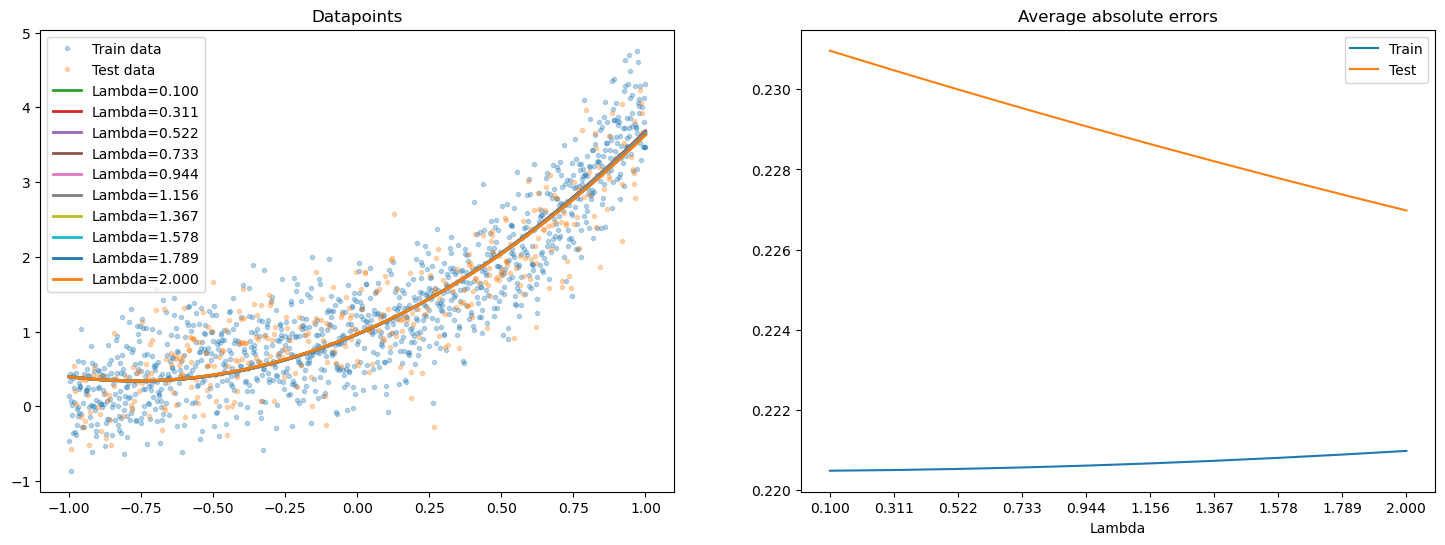

>>>>> K = 5 <<<<<
Lambda=0.100 | Avg absolute error: [test] 0.20842389967533054  | [train] 0.19750396264480122 
Lambda=0.311 | Avg absolute error: [test] 0.2080646823173858   | [train] 0.19759059280198674 
Lambda=0.522 | Avg absolute error: [test] 0.2077836040733266   | [train] 0.1977083392968435  
Lambda=0.733 | Avg absolute error: [test] 0.20754917287790006  | [train] 0.19783831721297637 
Lambda=0.944 | Avg absolute error: [test] 0.2073438172390237   | [train] 0.19797176316831258 
Lambda=1.156 | Avg absolute error: [test] 0.2071574219586796   | [train] 0.19810479516246962 
Lambda=1.367 | Avg absolute error: [test] 0.20698399535207693  | [train] 0.19823589670241898 
Lambda=1.578 | Avg absolute error: [test] 0.20681989602165807  | [train] 0.19836468850300112 
Lambda=1.789 | Avg absolute error: [test] 0.20666286054326038  | [train] 0.19849132155245364 
Lambda=2.000 | Avg absolute error: [test] 0.20651145479844646  | [train] 0.19861617556788458 


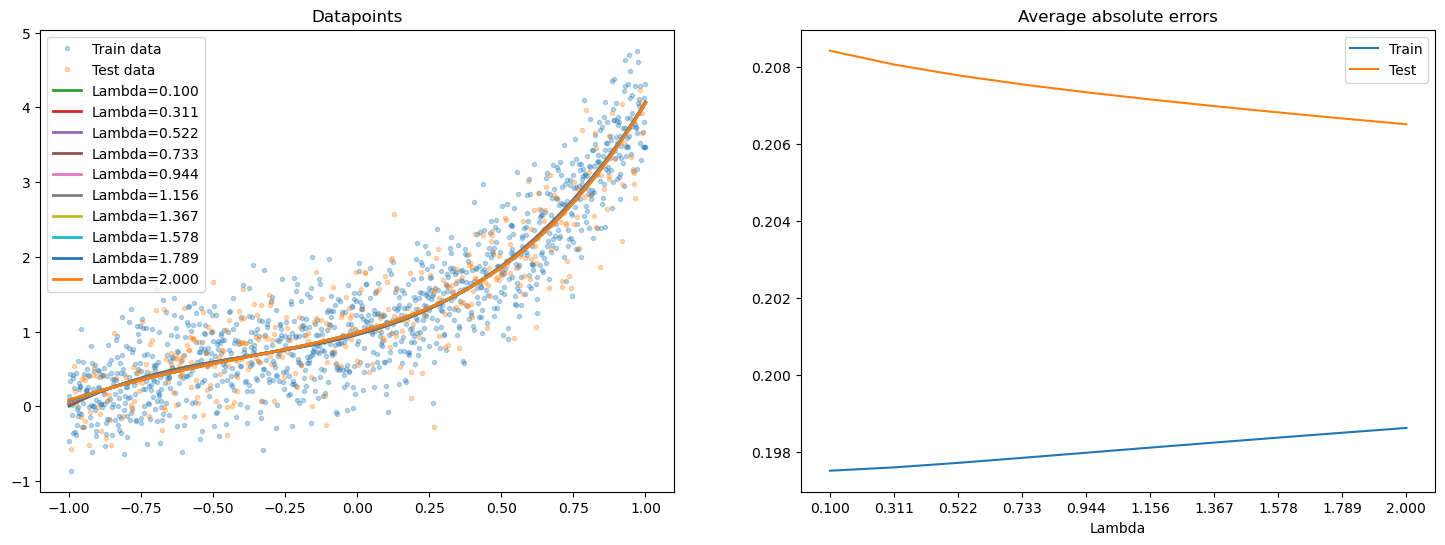

>>>>> K = 24 <<<<<
Lambda=0.100 | Avg absolute error: [test] 0.20883830265484604  | [train] 0.19662352071620454 
Lambda=0.311 | Avg absolute error: [test] 0.2085561365997704   | [train] 0.1967361158999025  
Lambda=0.522 | Avg absolute error: [test] 0.20830734147396857  | [train] 0.19684452774330746 
Lambda=0.733 | Avg absolute error: [test] 0.20808007947701473  | [train] 0.1969495338688074  
Lambda=0.944 | Avg absolute error: [test] 0.20786825774762147  | [train] 0.1970528094618669  
Lambda=1.156 | Avg absolute error: [test] 0.20766861234992187  | [train] 0.19715596322548193 
Lambda=1.367 | Avg absolute error: [test] 0.20747931821891658  | [train] 0.19726028718201088 
Lambda=1.578 | Avg absolute error: [test] 0.20729930369221855  | [train] 0.19736674601991838 
Lambda=1.789 | Avg absolute error: [test] 0.20712790186252467  | [train] 0.1974760333813615  
Lambda=2.000 | Avg absolute error: [test] 0.20696466826826315  | [train] 0.1975886358605081  


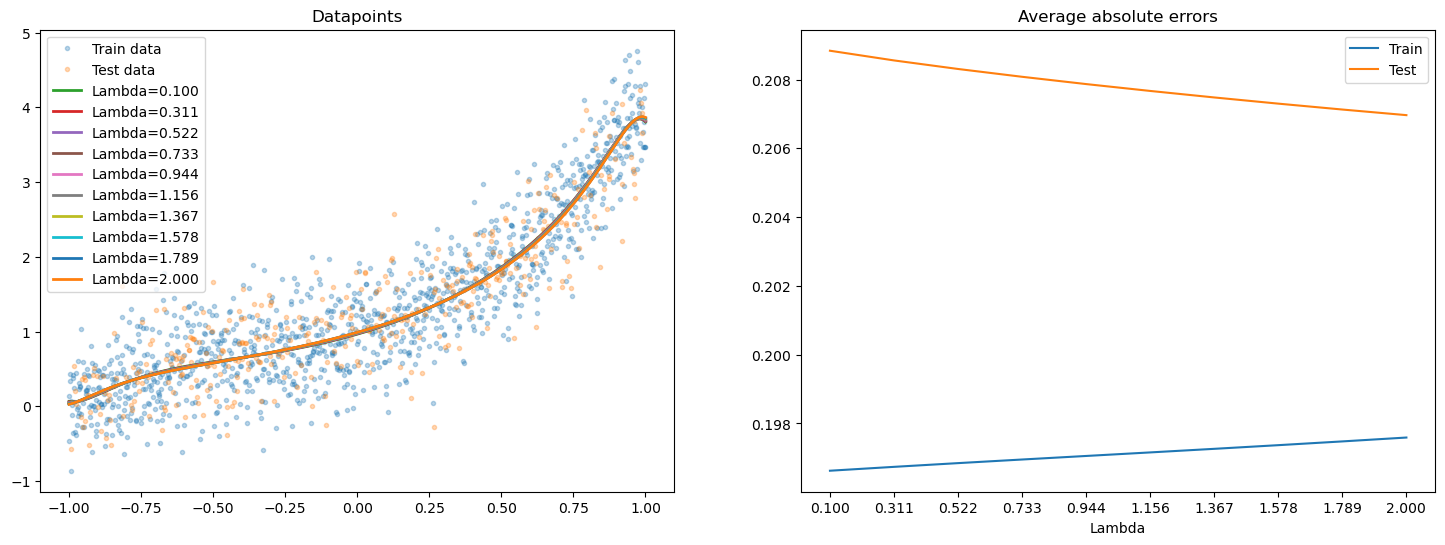

In [12]:
for try_K in [K-1, K+1, K+20]:
    print(f">>>>> K = {try_K} <<<<<")
    plotDataForVaryingLambda(MAPRegressor(K=try_K, lamb=None), X_train, Y_train, X_test, Y_test, to_try_lambda=np.linspace(0.1, 2, 10))

## MLE vs MAP

### Average absolute error for greater K

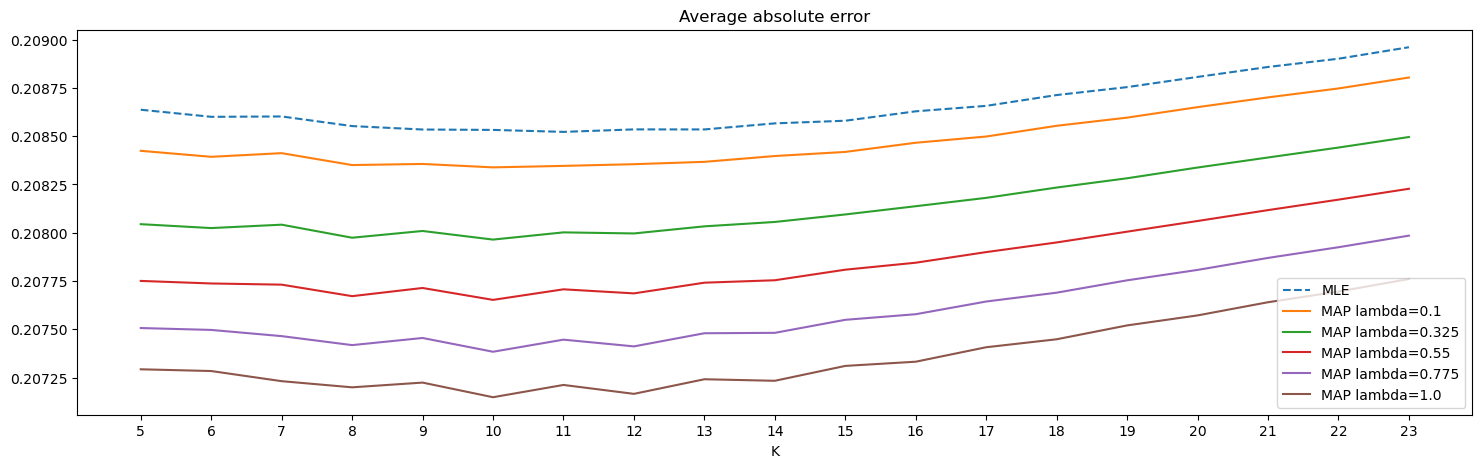

In [13]:
to_try_K = [K+i for i in range(1, 20)]
to_try_lambda = np.linspace(0.1, 1, 5)
mle_abs_errors = []
map_abs_errors = { l: [] for l in to_try_lambda }

for try_K in to_try_K:
    mle_model = MLERegressor(K=try_K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_abs_errors.append( avgAbsoluteError(mle_model, X_test, Y_test) )

    for i, lamb in enumerate(to_try_lambda):
        map_model = MAPRegressor(K=try_K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_abs_errors[lamb].append( avgAbsoluteError(map_model, X_test, Y_test) )

plt.figure(figsize=(18, 5))
plt.plot(to_try_K, mle_abs_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_K, map_abs_errors[lamb], label=f"MAP lambda={lamb}")
plt.title("Average absolute error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

### Theta error for greater K

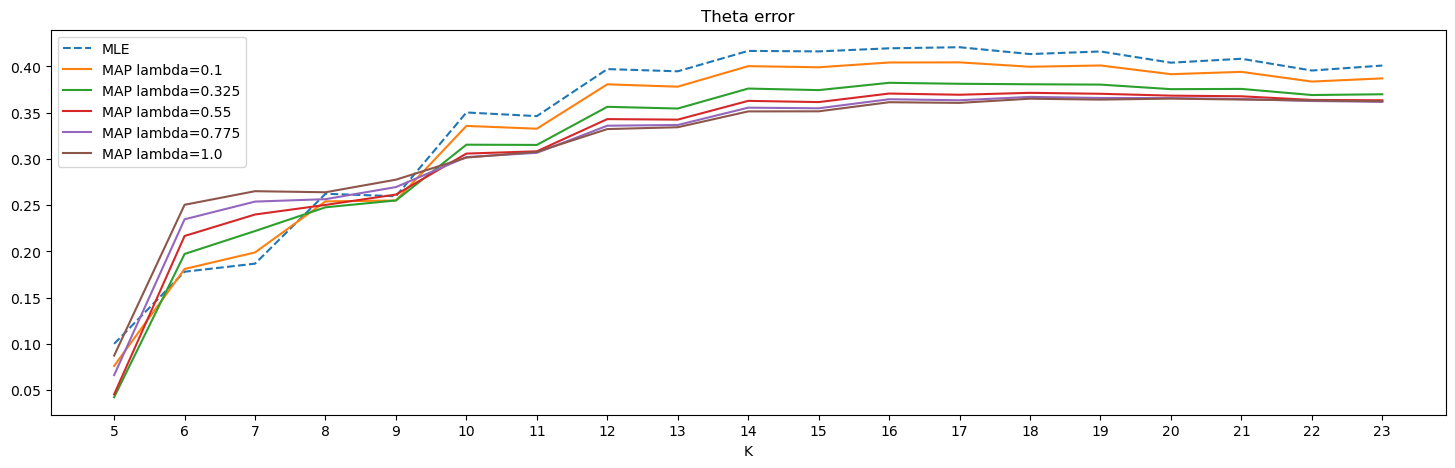

In [14]:
to_try_K = [K+i for i in range(1, 20)]
mle_theta_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_theta_errors = { l: [] for l in to_try_lambda }

for try_K in to_try_K:
    mle_model = MLERegressor(K=try_K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_theta_errors.append( thetaError(mle_model, theta_true) )

    for i, lamb in enumerate(to_try_lambda):
        map_model = MAPRegressor(K=try_K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_theta_errors[lamb].append( thetaError(map_model, theta_true) )

plt.figure(figsize=(18, 5))
plt.plot(to_try_K, mle_theta_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_K, map_theta_errors[lamb], label=f"MAP lambda={lamb}")
plt.title("Theta error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

### Different number of datapoints with correct K

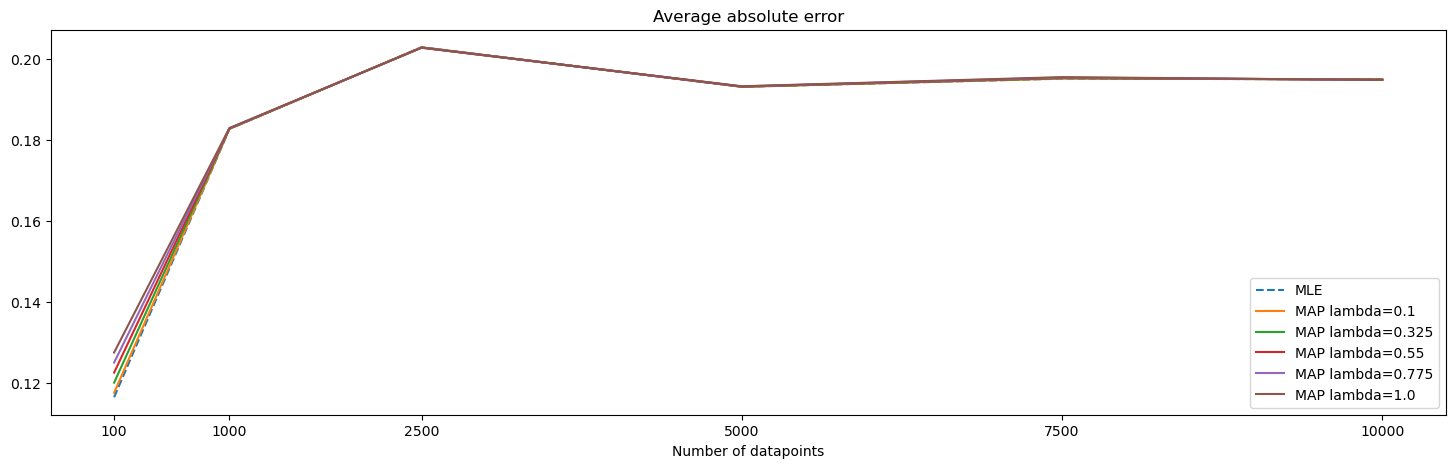

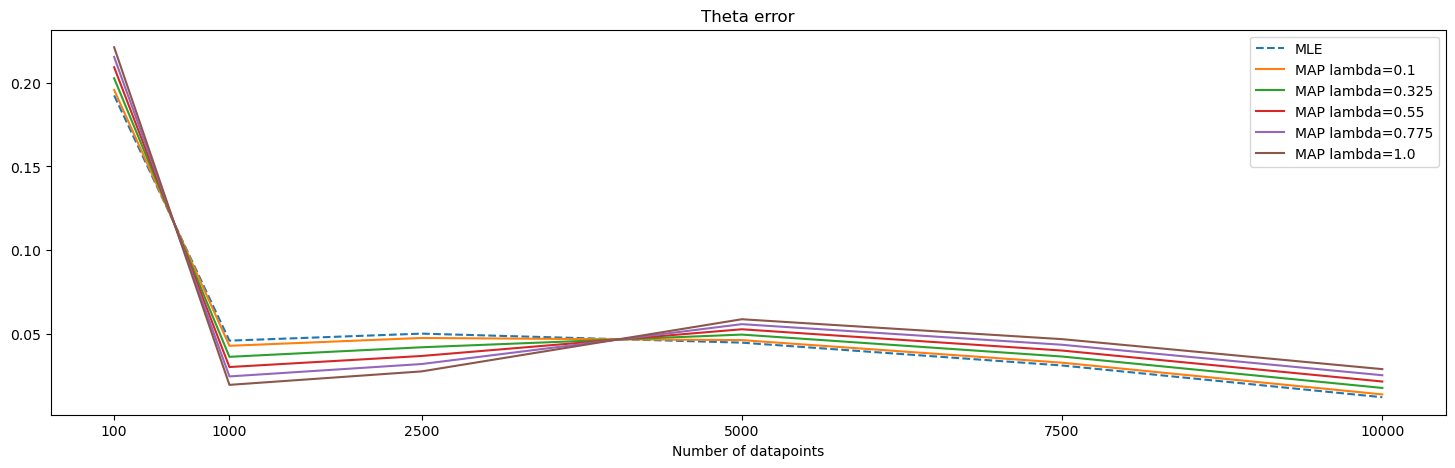

In [15]:
to_try_N = [100, 1000, 2500, 5000, 7500, 10000]
mle_abs_errors = []
mle_theta_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_abs_errors = { l: [] for l in to_try_lambda }
map_theta_errors = { l: [] for l in to_try_lambda }

for try_N in to_try_N:
    X_full, Y_full = createDataset(try_N, a, b, K, theta_true, variance)
    X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

    mle_model = MLERegressor(K=K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_abs_errors.append( avgAbsoluteError(mle_model, X_test, Y_test) )
    mle_theta_errors.append( thetaError(mle_model, theta_true) )
    
    for lamb in to_try_lambda:
        map_model = MAPRegressor(K=K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_abs_errors[lamb].append( avgAbsoluteError(map_model, X_test, Y_test) )
        map_theta_errors[lamb].append( thetaError(map_model, theta_true) )


plt.figure(figsize=(18, 5))
plt.title("Average absolute error")
plt.plot(to_try_N, mle_abs_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_N, map_abs_errors[lamb], label=f"MAP lambda={lamb}")
plt.xlabel("Number of datapoints")
plt.xticks(to_try_N)
plt.legend()
plt.show()

plt.figure(figsize=(18, 5))
plt.title("Theta error")
plt.plot(to_try_N, mle_theta_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_N, map_theta_errors[lamb], label=f"MAP lambda={lamb}")
plt.xlabel("Number of datapoints")
plt.xticks(to_try_N)
plt.legend()
plt.show()

### Different optimizers

In [16]:
X_full, Y_full = createDataset(N, a, b, K, theta_true, variance)
X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

          |        Theta error        |    Avg absolute error    
MLE (SGD) |       0.0484735223        |       0.2086130782       
MLE (GD)  |       0.0487067072        |       0.2087905734       
MLE (NEQ) |       0.0486958164        |       0.2087903990       
MAP (SGD) |       0.0479066793        |       0.2084505384       
MAP (GD)  |       0.0485062580        |       0.2087370869       
MAP (NEQ) |       0.0484947279        |       0.2087369106       


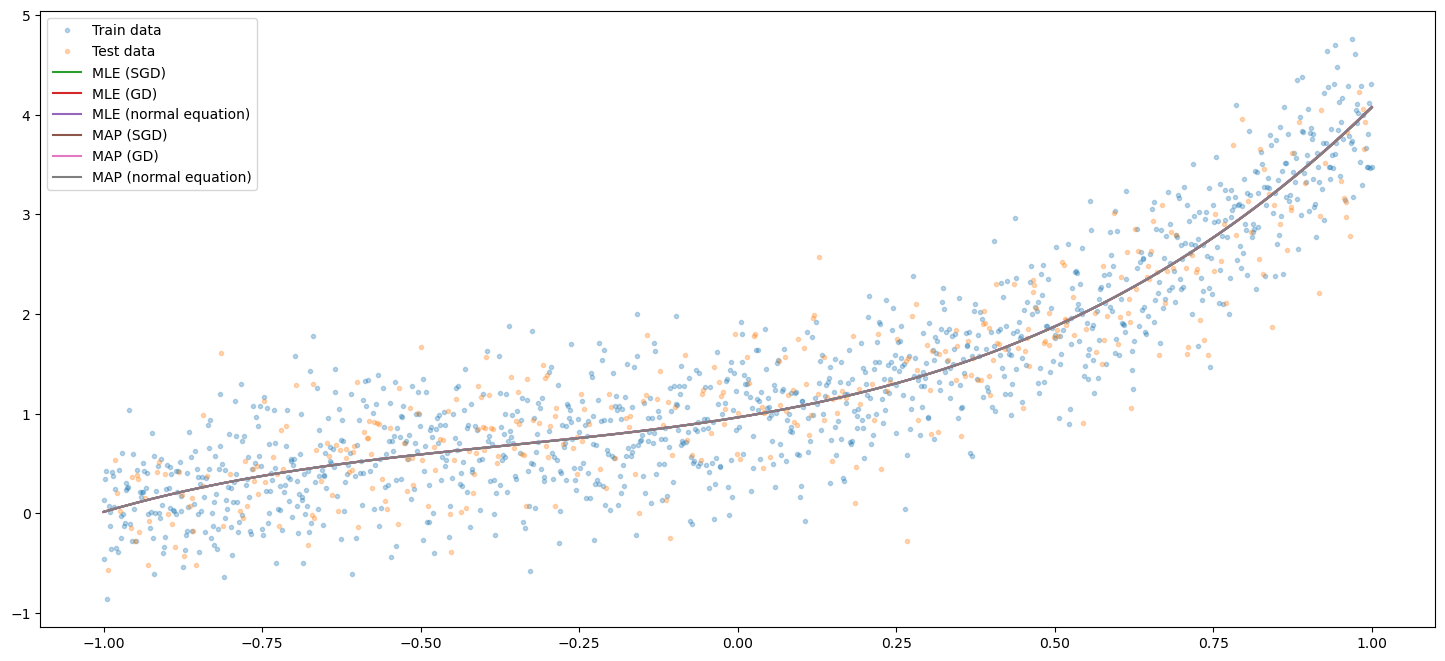

In [17]:
mle_model_sgd = MLERegressor(K=K).fit(X_train, Y_train, epochs=1000)
mle_model_gd = MLERegressor(K=K).fit_gd(X_train, Y_train, epochs=1000)
mle_model_neq = MLERegressor(K=K).fit_neq(X_train, Y_train)
map_model_sgd = MAPRegressor(K=K, lamb=0.1).fit(X_train, Y_train, epochs=1000)
map_model_gd = MAPRegressor(K=K, lamb=0.1).fit_gd(X_train, Y_train, epochs=1000)
map_model_neq = MAPRegressor(K=K, lamb=0.1).fit_neq(X_train, Y_train)


print(f"          | {'Theta error':^25} | {'Avg absolute error':^25}")

print(f"MLE (SGD) | {thetaError(mle_model_sgd, theta_true):^25.10f} | {avgAbsoluteError(mle_model_sgd, X_test, Y_test):^25.10f}")
print(f"MLE (GD)  | {thetaError(mle_model_gd, theta_true):^25.10f} | {avgAbsoluteError(mle_model_gd, X_test, Y_test):^25.10f}")
print(f"MLE (NEQ) | {thetaError(mle_model_neq, theta_true):^25.10f} | {avgAbsoluteError(mle_model_neq, X_test, Y_test):^25.10f}")

print(f"MAP (SGD) | {thetaError(map_model_sgd, theta_true):^25.10f} | {avgAbsoluteError(map_model_sgd, X_test, Y_test):^25.10f}")
print(f"MAP (GD)  | {thetaError(map_model_gd, theta_true):^25.10f} | {avgAbsoluteError(map_model_gd, X_test, Y_test):^25.10f}")
print(f"MAP (NEQ) | {thetaError(map_model_neq, theta_true):^25.10f} | {avgAbsoluteError(map_model_neq, X_test, Y_test):^25.10f}")


plt.figure(figsize=(18, 8))
plt.plot(X_train, Y_train, ".", alpha=0.3, label="Train data")
plt.plot(X_test, Y_test, ".", alpha=0.3, label="Test data")
plot_X = np.linspace(a, b, 10000)
plt.plot(plot_X, mle_model_sgd.predict(plot_X), label="MLE (SGD)")
plt.plot(plot_X, mle_model_gd.predict(plot_X), label="MLE (GD)")
plt.plot(plot_X, mle_model_neq.predict(plot_X), label="MLE (normal equation)")
plt.plot(plot_X, map_model_sgd.predict(plot_X), label="MAP (SGD)")
plt.plot(plot_X, map_model_gd.predict(plot_X), label="MAP (GD)")
plt.plot(plot_X, map_model_neq.predict(plot_X), label="MAP (normal equation)")
plt.legend()
plt.show()

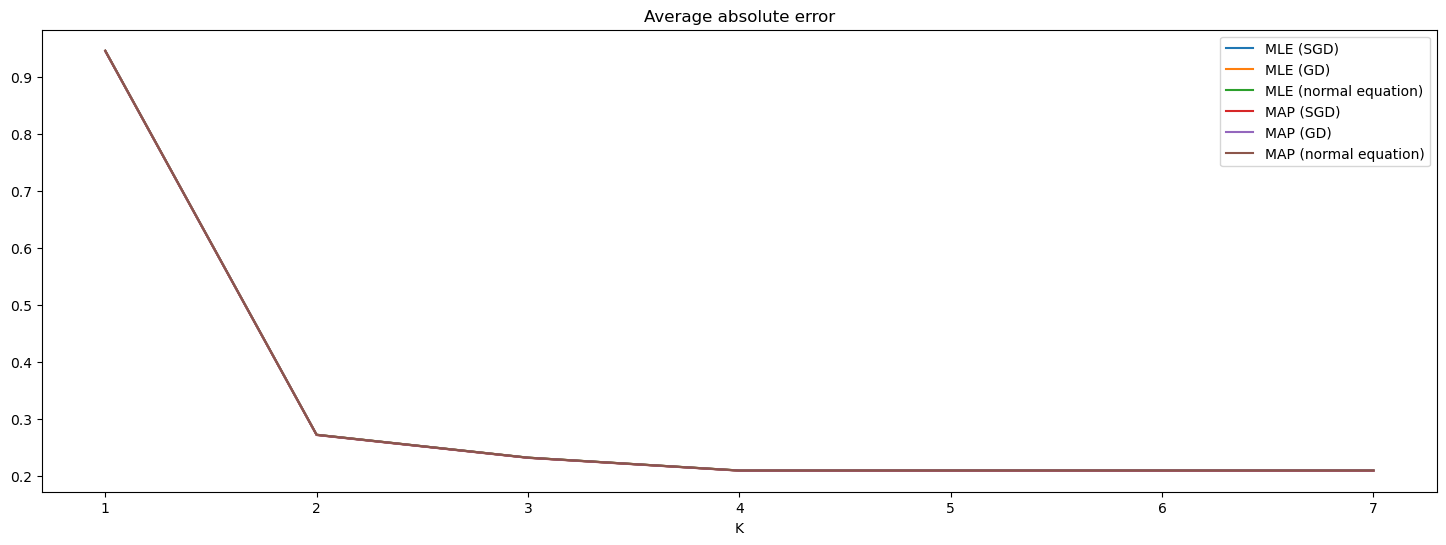

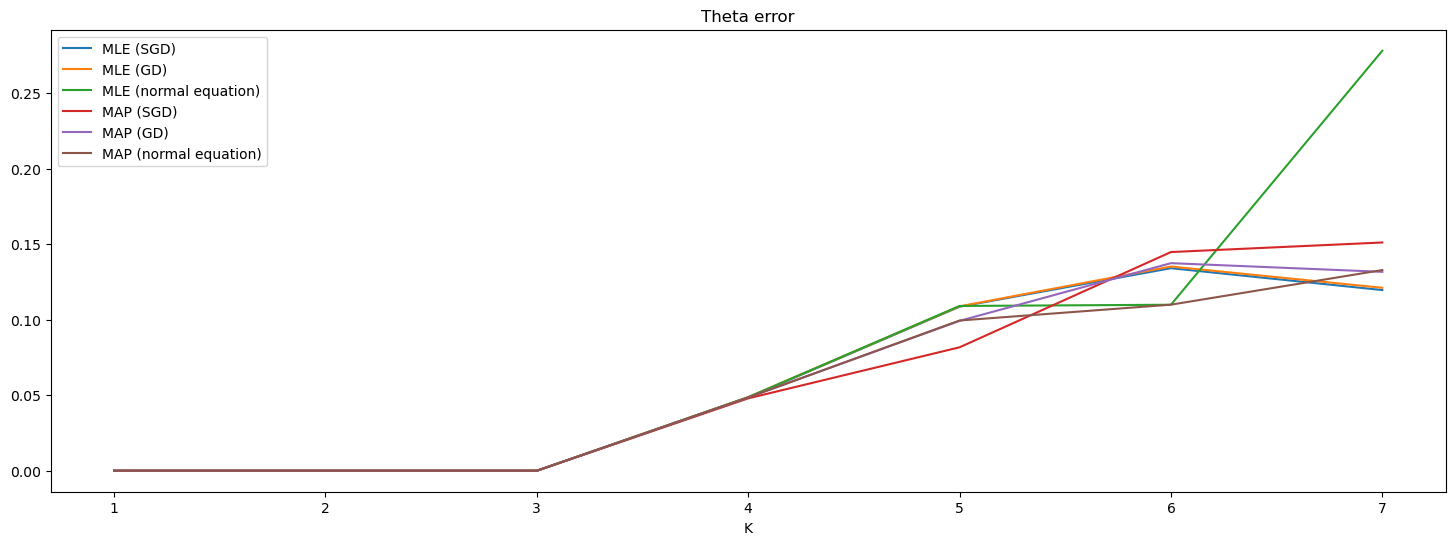

In [19]:
to_try_K = [*range(max(1, K-3), K)] + [K] + [*range(K+1, K+4)]
mle_sgd_abs_errors = []
mle_gd_abs_errors = []
mle_neq_abs_errors = []
map_sgd_abs_errors = []
map_gd_abs_errors = []
map_neq_abs_errors = []
mle_sgd_theta_errors = []
mle_gd_theta_errors = []
mle_neq_theta_errors = []
map_sgd_theta_errors = []
map_gd_theta_errors = []
map_neq_theta_errors = []

for try_K in to_try_K:
    mle_model_sgd = MLERegressor(K=try_K).fit(X_train, Y_train, epochs=2000)
    mle_model_gd = MLERegressor(K=try_K).fit_gd(X_train, Y_train, epochs=2000)
    mle_model_neq = MLERegressor(K=try_K).fit_neq(X_train, Y_train)
    map_model_sgd = MAPRegressor(K=try_K, lamb=0.1).fit(X_train, Y_train, epochs=2000)
    map_model_gd = MAPRegressor(K=try_K, lamb=0.1).fit_gd(X_train, Y_train, epochs=2000)
    map_model_neq = MAPRegressor(K=try_K, lamb=0.1).fit_neq(X_train, Y_train)

    mle_sgd_abs_errors.append( avgAbsoluteError(mle_model_sgd, X_test, Y_test) )
    mle_gd_abs_errors.append( avgAbsoluteError(mle_model_gd, X_test, Y_test) )
    mle_neq_abs_errors.append( avgAbsoluteError(mle_model_neq, X_test, Y_test) )
    map_sgd_abs_errors.append( avgAbsoluteError(map_model_sgd, X_test, Y_test) )
    map_gd_abs_errors.append( avgAbsoluteError(map_model_gd, X_test, Y_test) )
    map_neq_abs_errors.append( avgAbsoluteError(map_model_neq, X_test, Y_test) )
    if try_K >= K:
        mle_sgd_theta_errors.append( thetaError(mle_model_sgd, theta_true) )
        mle_gd_theta_errors.append( thetaError(mle_model_gd, theta_true) )
        mle_neq_theta_errors.append( thetaError(mle_model_neq, theta_true) )
        map_sgd_theta_errors.append( thetaError(map_model_sgd, theta_true) )
        map_gd_theta_errors.append( thetaError(map_model_gd, theta_true) )
        map_neq_theta_errors.append( thetaError(map_model_neq, theta_true) )
    else:
        mle_sgd_theta_errors.append(0)
        mle_gd_theta_errors.append(0)
        mle_neq_theta_errors.append(0)
        map_sgd_theta_errors.append(0)
        map_gd_theta_errors.append(0)
        map_neq_theta_errors.append(0)
    
plt.figure(figsize=(18, 6))
plt.plot(to_try_K, mle_sgd_abs_errors, label="MLE (SGD)")
plt.plot(to_try_K, mle_gd_abs_errors, label="MLE (GD)")
plt.plot(to_try_K, mle_neq_abs_errors, label="MLE (normal equation)")
plt.plot(to_try_K, map_sgd_abs_errors, label="MAP (SGD)")
plt.plot(to_try_K, map_gd_abs_errors, label="MAP (GD)")
plt.plot(to_try_K, map_neq_abs_errors, label="MAP (normal equation)")
plt.title("Average absolute error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(to_try_K, mle_sgd_theta_errors, label="MLE (SGD)")
plt.plot(to_try_K, mle_gd_theta_errors, label="MLE (GD)")
plt.plot(to_try_K, mle_neq_theta_errors, label="MLE (normal equation)")
plt.plot(to_try_K, map_sgd_theta_errors, label="MAP (SGD)")
plt.plot(to_try_K, map_gd_theta_errors, label="MAP (GD)")
plt.plot(to_try_K, map_neq_theta_errors, label="MAP (normal equation)")
plt.title("Theta error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()